# Setup

In [1]:
# Standard library imports
import warnings

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

# Configuration
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('fivethirtyeight')

This code imports the necessary libraries for time series analysis and visualization in Python.

First, `import warnings` brings in the `warnings` module. This is used to manage warning messages that might appear during code execution.  Often these are informational but can clutter output; we’ll see how it’s used shortly to suppress certain types of warnings.

Next, several third-party libraries are imported:

*   `import matplotlib.pyplot as plt`: `matplotlib` is a powerful plotting library. We import its `pyplot` module and give it the alias `plt`, which is standard practice. This allows us to create charts and graphs easily.
*   `import numpy as np`:  `numpy` provides support for numerical operations, especially with arrays. It's fundamental for many scientific computing tasks in Python. We use the alias `np`.
*   `import pandas as pd`: `pandas` is a library built on top of NumPy that provides data structures like DataFrames, which are excellent for working with tabular data (like time series).  The alias `pd` is standard.
*   `from sklearn.metrics import mean_absolute_error, mean_squared_error`: This imports specific functions from the `sklearn` (scikit-learn) library. These functions (`mean_absolute_error` and `mean_squared_error`) are used to evaluate the accuracy of our time series forecasting models by calculating how close our predictions are to the actual values.
*   `from statsmodels.graphics.tsaplots import plot_acf, plot_pacf`:  `statsmodels` is a library focused on statistical modeling. Here we're importing functions for visualizing *autocorrelation* and *partial autocorrelation*. These plots (`plot_acf`, `plot_pacf`) are crucial tools for understanding the relationships within a time series and choosing appropriate models.
*   `from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt, SimpleExpSmoothing`: This imports classes from `statsmodels` that implement different *exponential smoothing* methods. These are common techniques for forecasting time series data.  `ExponentialSmoothing` is a general class, while `Holt` and `SimpleExpSmoothing` represent specific variations of the technique.
*   `from statsmodels.tsa.seasonal import seasonal_decompose`: This imports a function that allows us to break down a time series into its constituent parts: trend, seasonality, and residual (random noise).  This is helpful for understanding the underlying patterns in the data.

Finally, there are two configuration lines:

*   `warnings.simplefilter(action='ignore', category=FutureWarning)`: This line tells Python to ignore `FutureWarning` messages. These warnings indicate that a feature you're using might be deprecated (removed) in a future version of the library.  While it’s good practice to eventually update your code, ignoring these can keep output cleaner during initial exploration.
*   `plt.style.use('fivethirtyeight')`: This sets the visual style for `matplotlib` plots to 'fivethirtyeight'. This is a pre-defined style that provides a specific look and feel (color scheme, font sizes, etc.) often used in data visualizations.  It's purely aesthetic and doesn’t affect the functionality of the code.

In [2]:
class CFG:
    SEASONAL_PERIOD = 12
    ACF_LAGS = 12
    data_folder = './data/'
    img_dim1 = 20
    img_dim2 = 10
    SEED = 42

# display style 
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (CFG.img_dim1, CFG.img_dim2)


np.random.seed(CFG.SEED)

This code defines a configuration class and sets up some display settings for plotting. 

First, the `class CFG:` block creates a class named `CFG`. This is a common practice in Python to group related constants or parameters together. Think of it as a container for settings that will be used throughout your program. Inside this class:

*   `SEASONAL_PERIOD = 12`:  This defines a constant representing the length of the seasonal cycle in your time series data. A value of 12 suggests monthly seasonality (like yearly patterns repeating every 12 months).
*   `ACF_LAGS = 12`: This sets the number of lags to consider when calculating the Autocorrelation Function (ACF). The ACF helps identify how strongly past values are correlated with current values in a time series.  Using 12 lags means we'll look at correlations up to 12 time periods into the past.
*   `data_folder = './data/'`: This specifies the path to the directory where your time series data is stored. The `./` indicates the current working directory, so it’s looking for a folder named “data” within the same location as your Python script.
*   `img_dim1 = 20` and `img_dim2 = 10`: These define the dimensions (width and height) of the plots you'll be creating using `matplotlib`.  
*   `SEED = 42`: This sets a seed for the random number generator. Setting a seed ensures that any random processes in your code (like data shuffling or initialization) will produce the same results every time you run it.  This is important for reproducibility – meaning others can verify your work. The value 42 is often used as a default, but any integer will work.

Following the class definition:

*   `plt.style.use("seaborn-v0_8")`: This line changes the visual style of `matplotlib` plots to "seaborn-v0_8". Seaborn is another Python visualization library that builds on top of Matplotlib and provides a more aesthetically pleasing default style.  The “v0\_8” specifies a particular version of the seaborn style.
*   `plt.rcParams["figure.figsize"] = (CFG.img_dim1, CFG.img_dim2)`: This line sets the default size of all figures created with `matplotlib`. It uses the values defined in the `CFG` class for the width (`img_dim1`) and height (`img_dim2`).  `plt.rcParams` is a dictionary-like object that controls various aspects of Matplotlib's behavior.
*   `np.random.seed(CFG.SEED)`: This sets the seed for NumPy’s random number generator, using the value defined in the `CFG` class (`SEED`).  As mentioned earlier, this ensures reproducibility of any random operations performed with NumPy.

# Functions

In [3]:
def train_valid_split(df, split_date, value_col="value"):
    train = df.loc[:split_date].copy()
    valid = df.loc[split_date:].copy()
    return train, valid

This function `train_valid_split` divides a time series DataFrame into training and validation sets based on a specified date. It’s a crucial step in preparing data for forecasting models – you need to train your model on some portion of the historical data and then evaluate its performance on unseen data (the validation set).


*   `def train_valid_split(df, split_date, value_col="value"):`: This defines a function named `train_valid_split` that takes three arguments:
    *   `df`:  This is the input DataFrame containing your time series data. It's assumed to have a datetime index (meaning the rows are indexed by dates).
    *   `split_date`: This is a date string or datetime object that determines where to split the data. All data *up to and including* this date will be used for training, and all data *after* this date will be used for validation.
    *   `value_col="value"`:  This specifies the name of the column in your DataFrame that contains the time series values you want to forecast. It defaults to "value", but you can change it if your column has a different name.

*   `train = df.loc[:split_date].copy()`: This line creates the training set.
    *   `df.loc[:split_date]` selects all rows from the DataFrame `df` where the index (the date) is less than or equal to `split_date`.  The `:` before `split_date` means "from the beginning of the DataFrame up to and including this date".
    *   `.copy()` creates a new DataFrame that is a copy of the selected data. This is important because it prevents modifications to the training set from accidentally affecting the original DataFrame or the validation set.

*   `valid = df.loc[split_date:].copy()`:  This line creates the validation set.
    *   `df.loc[split_date:]` selects all rows from the DataFrame `df` where the index (the date) is greater than or equal to `split_date`. The `:` after `split_date` means "from this date to the end of the DataFrame".
    *   `.copy()` again creates a new, independent copy of the selected data.

*   `return train, valid`:  The function returns two DataFrames: `train` (containing the training data) and `valid` (containing the validation data).

In [4]:
def forecast_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False),
    }

This function `forecast_metrics` calculates and returns common error metrics used to evaluate the accuracy of time series forecasts. It provides a concise way to assess how well your model's predictions align with the actual observed values.

*   `def forecast_metrics(y_true, y_pred):`: This defines a function named `forecast_metrics` that takes two arguments:
    *   `y_true`:  This represents the actual (observed) values of your time series. It's typically a NumPy array or Pandas Series.
    *   `y_pred`: This represents the predicted values generated by your forecasting model. It should have the same length as `y_true`.

*   `return { ... }`: The function returns a dictionary containing the calculated error metrics. Dictionaries are useful for storing key-value pairs, making it easy to access specific metrics by their names.

*   `"MAE": mean_absolute_error(y_true, y_pred),`: This calculates the Mean Absolute Error (MAE).
    *   `mean_absolute_error(y_true, y_pred)`:  This function from `sklearn.metrics` computes the average absolute difference between the true values (`y_true`) and the predicted values (`y_pred`). MAE gives equal weight to all errors.
    *   `"MAE": ...`: This assigns the calculated MAE value to the key "MAE" in the dictionary.

*   `"RMSE": mean_squared_error(y_true, y_pred, squared=False),`:  This calculates the Root Mean Squared Error (RMSE).
    *   `mean_squared_error(y_true, y_pred, squared=False)`: This function from `sklearn.metrics` computes the square root of the average squared difference between the true and predicted values. The `squared=False` argument ensures that we get the RMSE directly (the square root), rather than the Mean Squared Error (MSE).  RMSE penalizes larger errors more heavily than MAE because of the squaring operation.
    *   `"RMSE": ...`: This assigns the calculated RMSE value to the key "RMSE" in the dictionary.

In [5]:
def evaluate_forecast(
    model_fit,
    train_df,
    valid_df,
    value_col="value",
    title=None,
):
    forecast = model_fit.forecast(len(valid_df))
    residuals = valid_df[value_col] - forecast

    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    # Forecast plot
    train_df[value_col].plot(ax=axes[0, 0], label="Train")
    valid_df[value_col].plot(ax=axes[0, 0], label="Validation")
    forecast.plot(ax=axes[0, 0], label="Forecast")
    axes[0, 0].legend()
    axes[0, 0].set_title(title or "Forecast vs Actual")

    # Residuals
    residuals.plot(ax=axes[0, 1], title="Residuals")

    plot_acf(residuals, lags= CFG.ACF_LAGS, ax=axes[1, 0])
    plot_pacf(residuals, lags=CFG.ACF_LAGS, ax=axes[1, 1])

    plt.tight_layout()
    plt.show()

    metrics = forecast_metrics(valid_df[value_col], forecast)
    return forecast, residuals, metrics

TODO

# Exponential smoothing

## Single ES

In [ ]:
def plot_ses_smoothing(series_df, alpha, horizon, value_col="series"):
    ses_model = SimpleExpSmoothing(series_df[value_col])
    ses_fit = ses_model.fit(  smoothing_level=alpha, optimized=False)

    forecast = ses_fit.forecast(horizon)
    plt.figure()

    # Original series
    series_df[value_col].plot( label="Observed", linewidth=2, )
    # Smoothed (fitted) values
    ses_fit.fittedvalues.plot( label=f"Smoothed (α={alpha})", linewidth=2 , color = "red"   )
    # Forecast
    forecast.plot( label="Forecast", marker="o", linestyle="--", color="green" )
    
    plt.legend()
    plt.show()


This helper function `plot_ses_smoothing` visualizes the results of applying Simple Exponential Smoothing (SES) to a time series, including both the smoothed values and forecasts. It’s designed to help you understand how SES works and assess its performance on your data.


*   `def plot_ses_smoothing(series_df, alpha, horizon, value_col="series"):`: This defines a function named `plot_ses_smoothing` that takes four arguments:
    *   `series_df`: A Pandas DataFrame containing your time series data. It's expected to have a column with the time series values.
    *   `alpha`: The smoothing level for SES, controlling how much weight is given to recent observations.
    *   `horizon`:  The number of periods into the future you want to forecast. This determines the length of the forecast horizon.
    *   `value_col="series"`: Specifies the name of the column in `series_df` that contains the time series values. It defaults to "series" but can be changed if your data uses a different column name.

*   `ses_model = SimpleExpSmoothing(series_df[value_col])`: This creates an instance of the `SimpleExpSmoothing` class, initializing it with the time series data from the specified column in the DataFrame.

*   `ses_fit = ses_model.fit(  smoothing_level=alpha, optimized=False)`: This fits (trains) the SES model to the data using the provided smoothing level (`alpha`). `optimized=False` prevents the model from automatically searching for the best alpha value; we're explicitly setting it.

*   `forecast = ses_fit.forecast(horizon)`:  This generates a forecast for the specified `horizon` (number of periods into the future) using the fitted SES model.

*   `plt.figure()`: This creates a new Matplotlib figure, which will contain the plot.

*   `series_df[value_col].plot( label="Observed", linewidth=2, )`:  This plots the original time series data as a line, with a width of 2. The `label="Observed"` assigns a label to this line for use in the legend.

*   `ses_fit.fittedvalues.plot( label=f"Smoothed (α={alpha})", linewidth=2 , color = "red"   )`: This plots the smoothed values generated by the SES model (the *in-sample fitted values*) as a line with a line width of 2 and red color. The `label` dynamically includes the value of `alpha` used for smoothing, making it clear which smoothing level was applied.  Using red helps visually distinguish the smoothed line from the original data.

*   `forecast.plot( label="Forecast", marker="o", linestyle="--", color="green" )`: This plots the forecasted values as a dashed line (`linestyle="--"`) with circular markers (`marker="o"`), and a green color. The `label="Forecast"` assigns a label for the legend.  The green color differentiates the forecast from both the observed data and the smoothed curve.

*   `plt.legend()`:  This displays the legend on the plot, showing the labels assigned to each line (Observed, Smoothed, Forecast). The different colors will be represented in the legend as well.

*   `plt.show()`: This displays the generated plot.

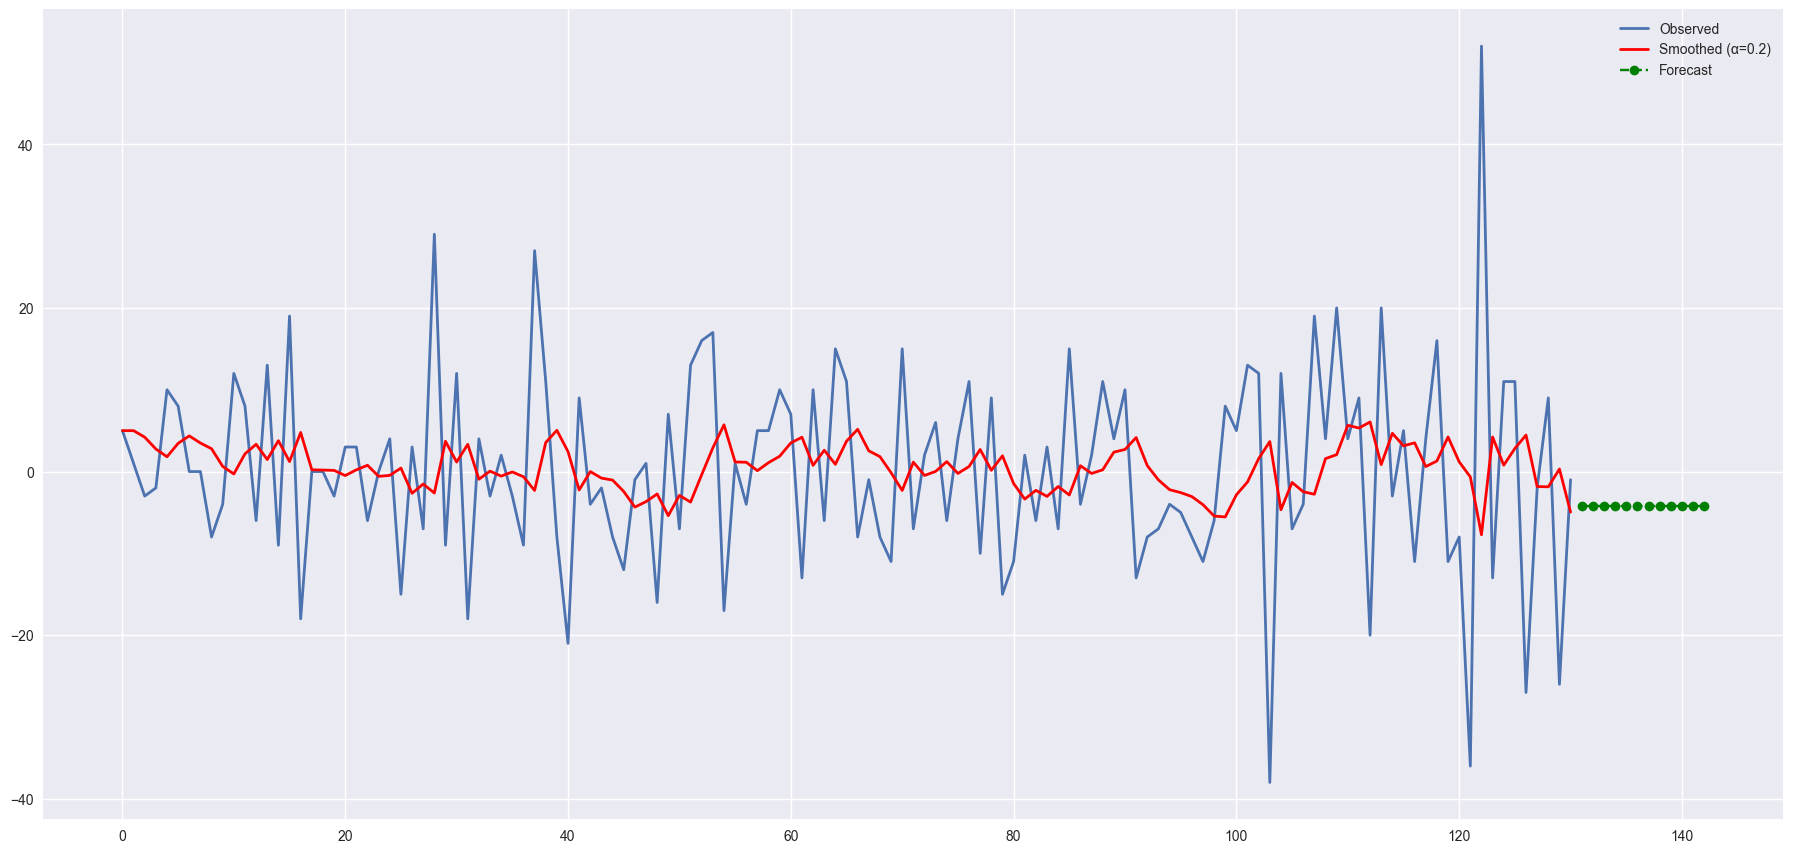

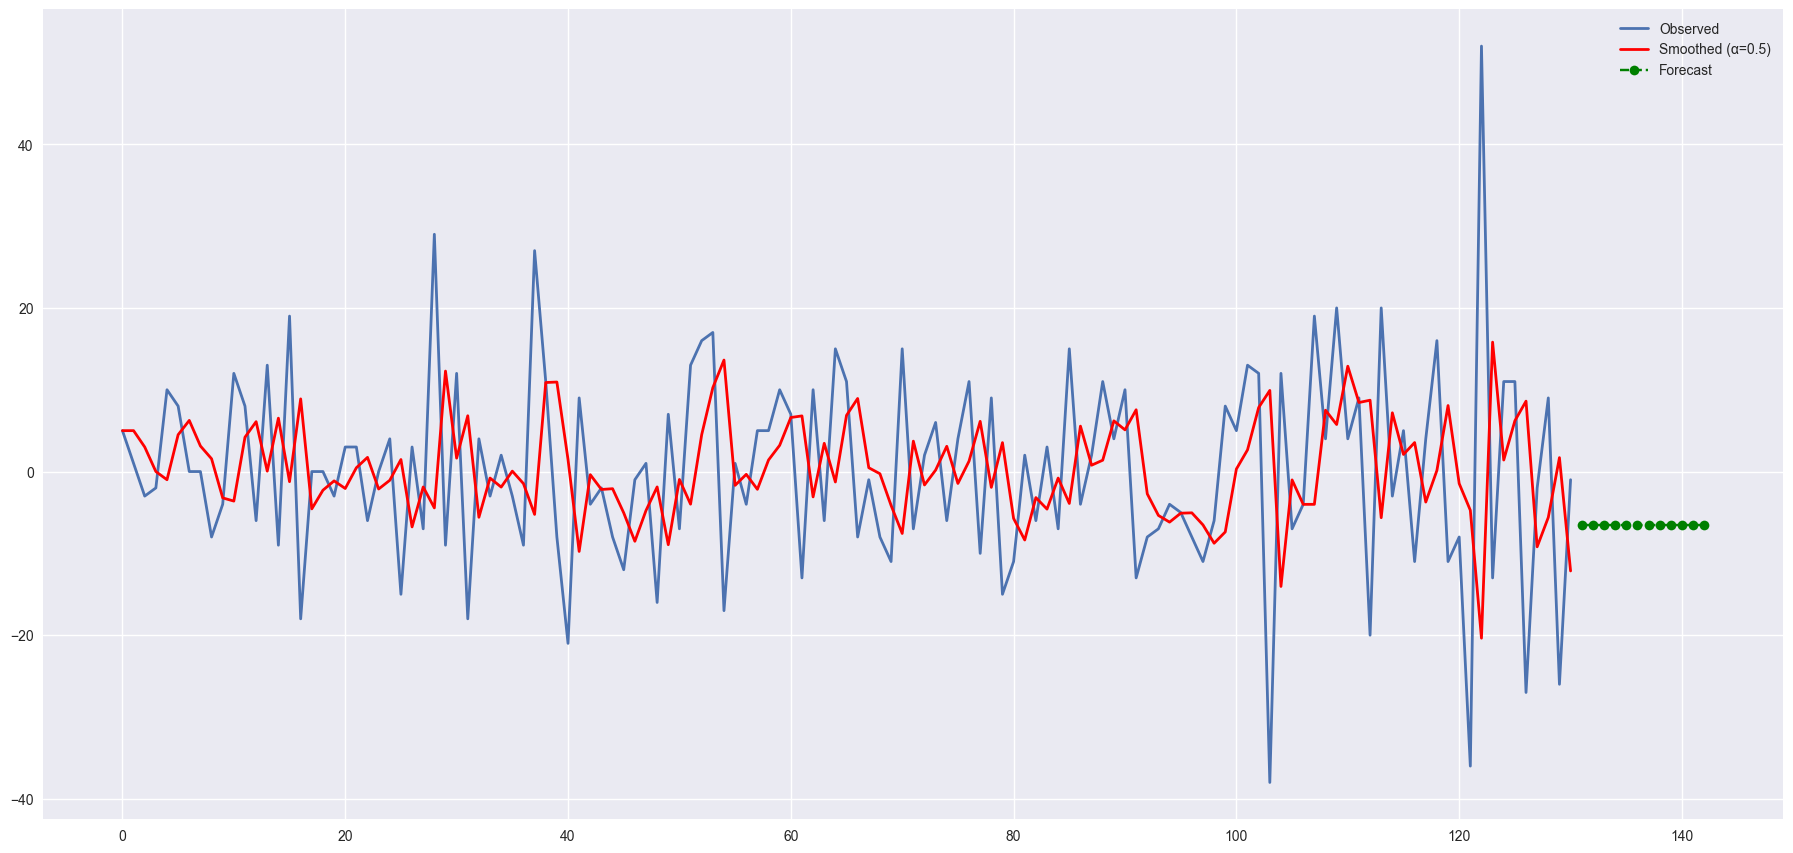

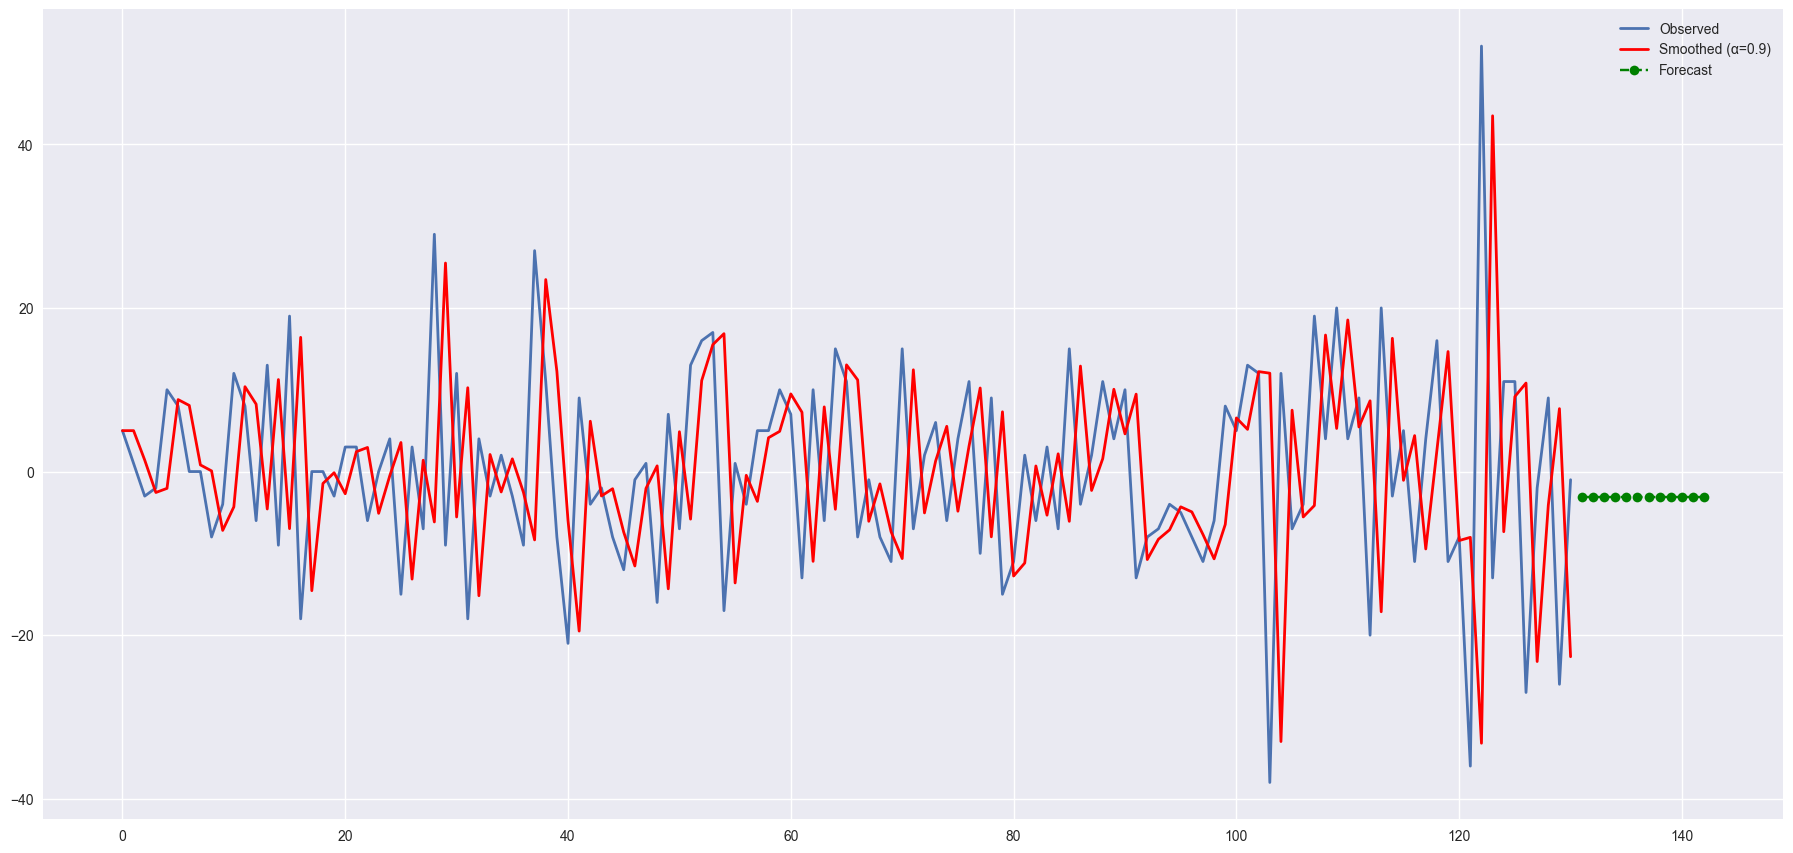

In [39]:
HORIZON = 12
ALPHAS = [0.2, 0.5, 0.9]

series_df = pd.read_csv(
    CFG.data_folder + "exp1.csv",
    header=None,names=["series"],
)

for alpha in ALPHAS:
    plot_ses_smoothing(series_df, alpha=alpha, horizon=HORIZON)

This code demonstrates the application of Simple Exponential Smoothing (SES) with different smoothing levels (`alpha`). 

*   `df = pd.read_csv(CFG.data_folder + 'exp1.csv', header = None); df.columns = ['series']`: This line reads data from a CSV file named "exp1.csv" located in the directory specified by `CFG.data_folder`.
    *   `pd.read_csv(...)`:  This is the Pandas function for reading data from a comma-separated value (CSV) file.
    *   `header = None`: This argument tells `read_csv` that the CSV file does *not* have a header row containing column names.
    *   `df.columns = ['series']`:  After reading the data, this line assigns the name "series" to the single column in the DataFrame.

*   `# synthetic data demonstration`: This is just a comment indicating that the following code demonstrates SES on some example (likely synthetic) time series data.

*   `for alpha_sm in [0.2 , 0.5, 0.9]:`:  This starts a loop that iterates through three different values for the smoothing level (`alpha_sm`): 0.2, 0.5, and 0.9. The smoothing level controls how much weight is given to recent observations versus past observations in the SES model.

*   `df.plot.line()`: This plots the original time series data as a line plot using Pandas' built-in plotting functionality.  This provides a visual baseline for comparison with the smoothed and forecasted values.

*   `fit1 = SimpleExpSmoothing(df).fit(smoothing_level = alpha_sm  ,optimized=False)`: This is where the SES model is fitted to the data.
    *   `SimpleExpSmoothing(df)`: Creates an instance of the `SimpleExpSmoothing` class from the `statsmodels` library, initializing it with your time series data (`df`).
    *   `.fit(smoothing_level = alpha_sm  ,optimized=False)`: This fits (trains) the SES model to the data.
        *   `smoothing_level = alpha_sm`: Sets the smoothing level for this particular iteration of the loop.
        *   `optimized=False`:  This is important! It tells `SimpleExpSmoothing` *not* to automatically find the optimal smoothing level using optimization techniques. We are explicitly setting it with `alpha_sm`. If set to `True`, the model would search for the best alpha value, which isn't what we want in this demonstration.

*   `fcast1 = fit1.forecast(12).rename('alpha = ' + str(alpha_sm))`: This generates a forecast using the fitted SES model.
    *   `fit1.forecast(12)`:  This uses the trained `fit1` model to predict the next 12 values in the time series.
    *   `.rename('alpha = ' + str(alpha_sm))`: This renames the forecast series to include the value of `alpha_sm` used for that particular forecast, making it easier to distinguish between forecasts generated with different smoothing levels on the plot's legend.

*   `fcast1.plot(marker='o', color='red', legend=True)`:  This plots the forecasted values as a line with circular markers ('o'), colored red, and includes a legend entry.

*   `fit1.fittedvalues.plot(  color='red')`: This plots the *in-sample fitted values*. These are the smoothed values that the model calculated for the data it was trained on (the original time series). Plotting these helps visualize how well the SES model fits the historical data. They're also colored red to match the forecast line.

*   `plt.show()`: This displays the plot, showing the original time series, the fitted values, and the forecasted values for a specific `alpha_sm`.  The loop then repeats with the next value of `alpha_sm`, creating a new plot each time.

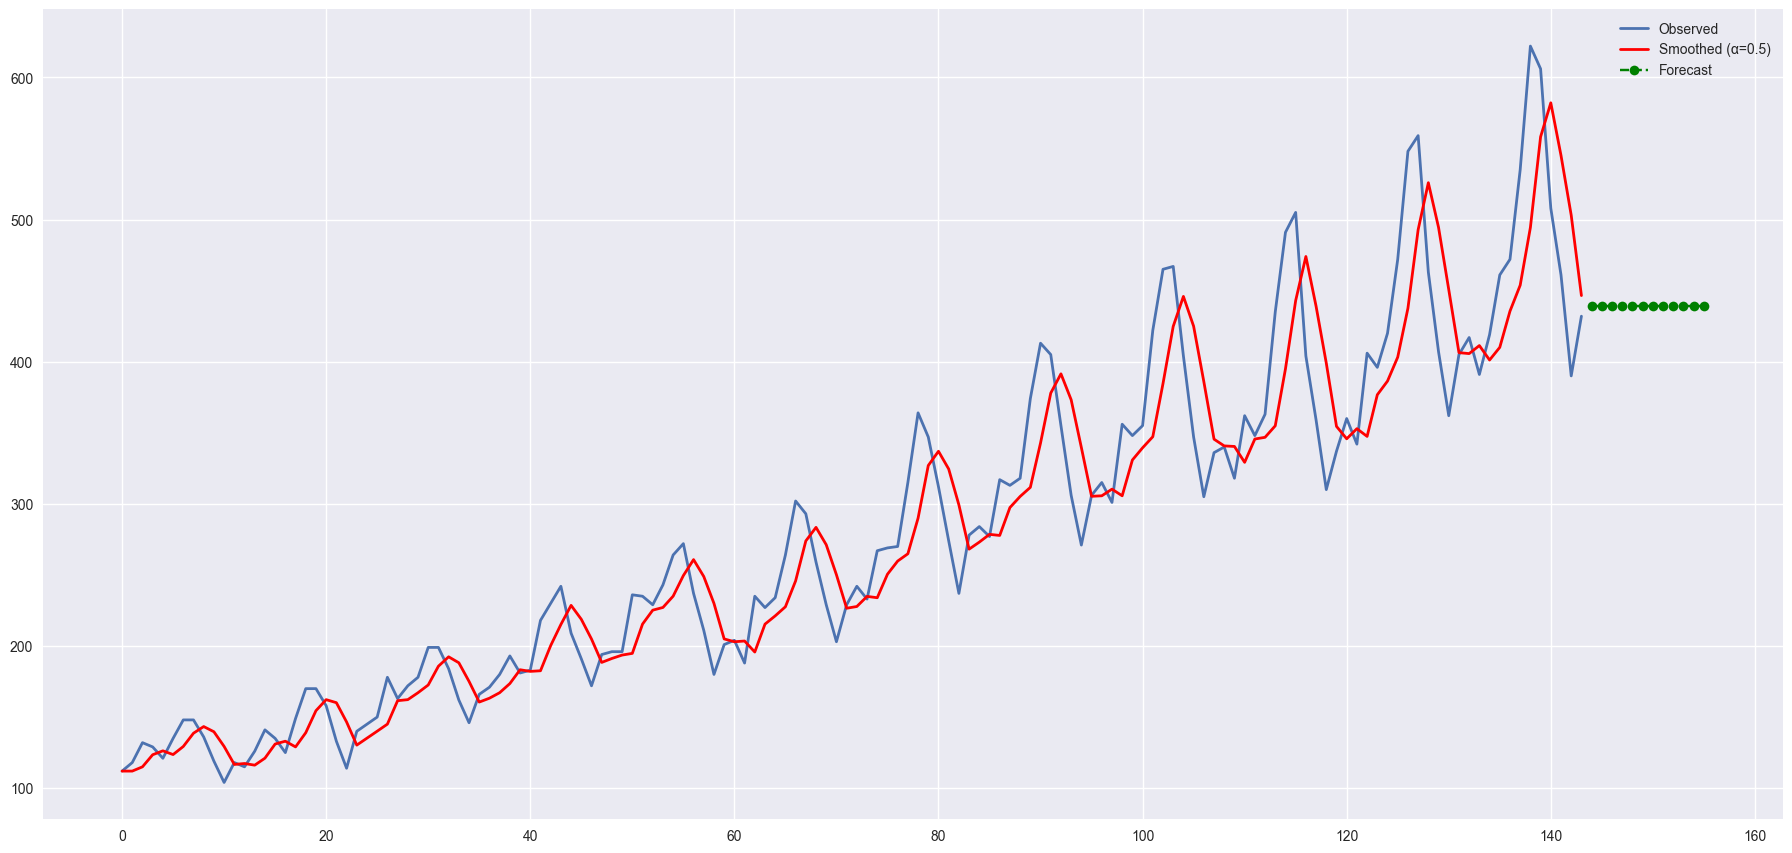

In [41]:
ALPHA = 0.5
HORIZON = 12

passengers_df = pd.read_csv( CFG.data_folder + "passengers.csv", usecols=["passengers"])

plot_ses_smoothing( passengers_df, alpha=ALPHA, horizon=HORIZON, value_col="passengers")

This code applies Simple Exponential Smoothing (SES) to a time series dataset of passenger numbers and visualizes the results using the `plot_ses_smoothing` function we've discussed. Let’s break it down:

*   `ALPHA = 0.5`: This line defines a constant variable named `ALPHA` and sets its value to 0.5.  This represents the smoothing level that will be used in the SES model. A value of 0.5 means that each new observation is given half the weight of the previous forecast, and the previous forecast receives the other half.

*   `HORIZON = 12`: This line defines a constant variable named `HORIZON` and sets its value to 12.  This represents the number of time periods into the future for which we want to generate forecasts. In this context, it likely means forecasting passenger numbers for the next 12 months (or whatever the time unit is in your dataset).

*   `passengers_df = pd.read_csv( CFG.data_folder + "passengers.csv", usecols=["passengers"])`: This line reads data from a CSV file named "passengers.csv" located in the directory specified by `CFG.data_folder`.
    *   `pd.read_csv(...)`:  This is the Pandas function for reading data from a comma-separated value (CSV) file.
    *   `usecols=["passengers"]`: This argument tells `read_csv` to only read the column named "passengers" from the CSV file, creating a DataFrame with just that single column.

*   `plot_ses_smoothing( passengers_df, alpha=ALPHA, horizon=HORIZON, value_col="passengers")`:  This line calls the `plot_ses_smoothing` function to perform SES and generate a visualization.
    *   `passengers_df`: This passes the DataFrame containing the passenger data as the first argument (`series_df`).
    *   `alpha=ALPHA`: This sets the smoothing level for the SES model to the value stored in the `ALPHA` variable (0.5).
    *   `horizon=HORIZON`:  This sets the forecast horizon to the value stored in the `HORIZON` variable (12).
    *   `value_col="passengers"`: This specifies that the column named "passengers" in the DataFrame contains the time series values.


## Double Exponential Smoothing


In [48]:
# wrapper function - similar to plot_ses_smoothing

def plot_holt_smoothing( series_df, alpha, beta, horizon,  value_col):
    holt_model = Holt(series_df[value_col])
    holt_fit = holt_model.fit(
        smoothing_level=alpha, smoothing_slope=beta, optimized=False,
    )

    forecast = holt_fit.forecast(horizon)

    plt.figure()

    series_df[value_col].plot(
        label="Observed", linewidth=2    )

    holt_fit.fittedvalues.plot( label=f"Smoothed (α={alpha}, β={beta})",linewidth=2, color = "red"     )

    forecast.plot( label="Forecast",  marker="o", linestyle="--", color="green" )


    plt.title("Holt’s Linear Trend Method")
    plt.legend()
    plt.show()


This code defines a function `plot_holt_smoothing` that visualizes the results of applying Holt's linear trend method to a time series dataset. It’s very similar in structure to the `plot_ses_smoothing` function we previously discussed, but it implements a more sophisticated smoothing technique that accounts for trends in the data.


*   `def plot_holt_smoothing( series_df, alpha, beta, horizon,  value_col):`: This defines a function named `plot_holt_smoothing` that takes five arguments:
    *   `series_df`: A Pandas DataFrame containing your time series data. It's expected to have a column with the time series values.
    *   `alpha`: The smoothing level for the level component of Holt’s method, controlling how much weight is given to recent observations when updating the current level.
    *   `beta`: The smoothing level for the trend component of Holt’s method, controlling how much weight is given to recent changes in the series when updating the trend.
    *   `horizon`:  The number of time periods into the future you want to forecast.
    *   `value_col`: Specifies the name of the column in `series_df` that contains the time series values.

*   `holt_model = Holt(series_df[value_col])`: This creates an instance of the `Holt` class from the `statsmodels` library, initializing it with the time series data from the specified column in the DataFrame.  The `Holt` method is designed for time series that exhibit a trend (increasing or decreasing pattern).

*   `holt_fit = holt_model.fit( smoothing_level=alpha, smoothing_slope=beta, optimized=False,)`: This fits (trains) the Holt’s model to the data using the provided smoothing levels for both the level (`alpha`) and trend (`beta`) components. `optimized=False` prevents automatic optimization of these parameters; we're explicitly setting them.

*   `forecast = holt_fit.forecast(horizon)`:  This generates a forecast for the specified `horizon` (number of periods into the future) using the fitted Holt’s model.

*   `plt.figure()`: This creates a new Matplotlib figure, which will contain the plot.

*   `series_df[value_col].plot( label="Observed", linewidth=2 )`:  This plots the original time series data as a line with a width of 2. The `label="Observed"` assigns a label to this line for use in the legend.

*   `holt_fit.fittedvalues.plot( label=f"Smoothed (α={alpha}, β={beta})",linewidth=2, color = "red" )`: This plots the smoothed values generated by Holt’s model (the *in-sample fitted values*) as a line with a line width of 2 and a **red** color. The `label` dynamically includes the values of both `alpha` and `beta`, making it clear which smoothing levels were used.

*   `forecast.plot( label="Forecast",  marker="o", linestyle="--", color="green" )`: This plots the forecasted values as a dashed line (`linestyle="--"`) with circular markers (`marker="o"`), and a **green** color. The `label="Forecast"` assigns a label for the legend.

*   `plt.title("Holt’s Linear Trend Method")`:  This sets the title of the plot to "Holt’s Linear Trend Method", indicating which forecasting method is being visualized.

*   `plt.legend()`:  This displays the legend on the plot, showing the labels assigned to each line (Observed, Smoothed, Forecast). The different colors will be represented in the legend as well.

*   `plt.show()`: This displays the generated plot.

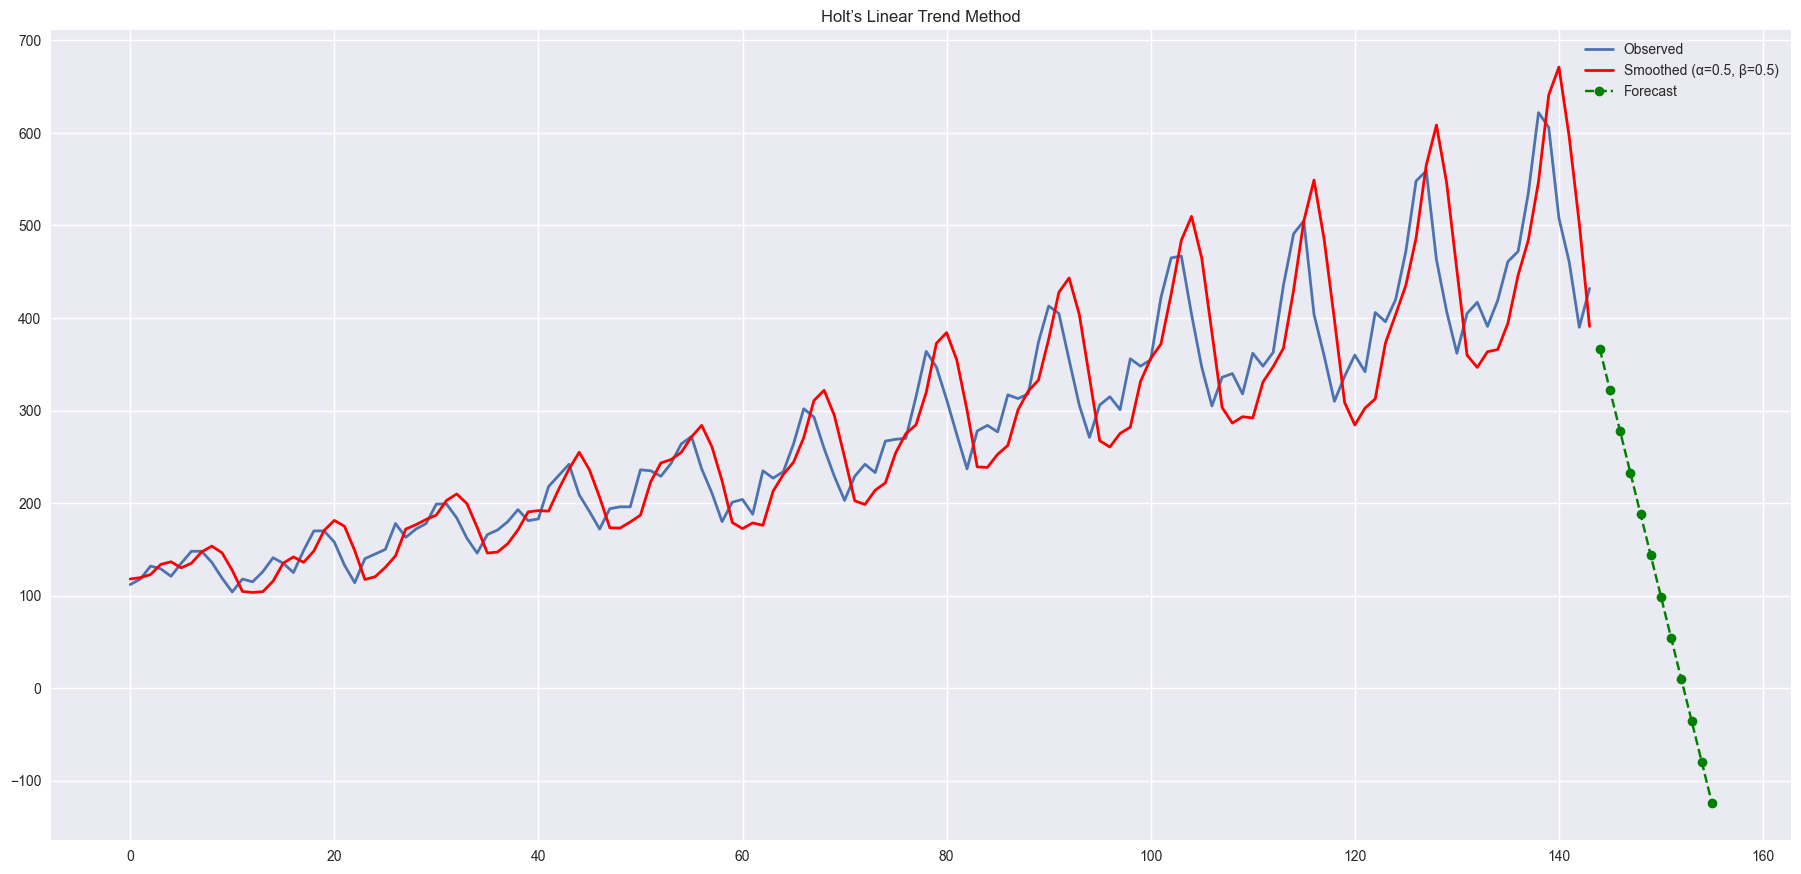

In [49]:
LEVEL_ALPHA = 0.5
TREND_BETA = 0.5
HORIZON = 12

plot_holt_smoothing(
    passengers_df, alpha=LEVEL_ALPHA,  beta=TREND_BETA, horizon=HORIZON,  value_col="passengers")

This code snippet applies Holt's linear trend method to the passenger data and visualizes the results using the `plot_holt_smoothing` function. 

*   `LEVEL_ALPHA = 0.5`: This line defines a constant variable named `LEVEL_ALPHA` and sets its value to 0.5.  This represents the smoothing level for the *level* component of Holt's method. It controls how much weight is given to recent observations when updating the current level of the series.

*   `TREND_BETA = 0.5`: This line defines a constant variable named `TREND_BETA` and sets its value to 0.5.  This represents the smoothing level for the *trend* component of Holt's method. It controls how much weight is given to recent changes in the series when updating the trend.

*   `HORIZON = 12`: This line defines a constant variable named `HORIZON` and sets its value to 12.  This represents the number of time periods into the future for which we want to generate forecasts. In this context, it likely means forecasting passenger numbers for the next 12 months (or whatever the time unit is in your dataset).

*   `plot_holt_smoothing( passengers_df, alpha=LEVEL_ALPHA,  beta=TREND_BETA, horizon=HORIZON,  value_col="passengers")`: This line calls the `plot_holt_smoothing` function to perform Holt's smoothing and generate a visualization.
    *   `passengers_df`: This passes the DataFrame containing the passenger data as the first argument (`series_df`).
    *   `alpha=LEVEL_ALPHA`: This sets the smoothing level for the level component of Holt’s method to the value stored in the `LEVEL_ALPHA` variable (0.5).
    *   `beta=TREND_BETA`:  This sets the smoothing level for the trend component of Holt’s method to the value stored in the `TREND_BETA` variable (0.5).
    *   `horizon=HORIZON`: This sets the forecast horizon to the value stored in the `HORIZON` variable (12).
    *   `value_col="passengers"`: This specifies that the column named "passengers" in the DataFrame contains the time series values.


## Triple exponential smoothing

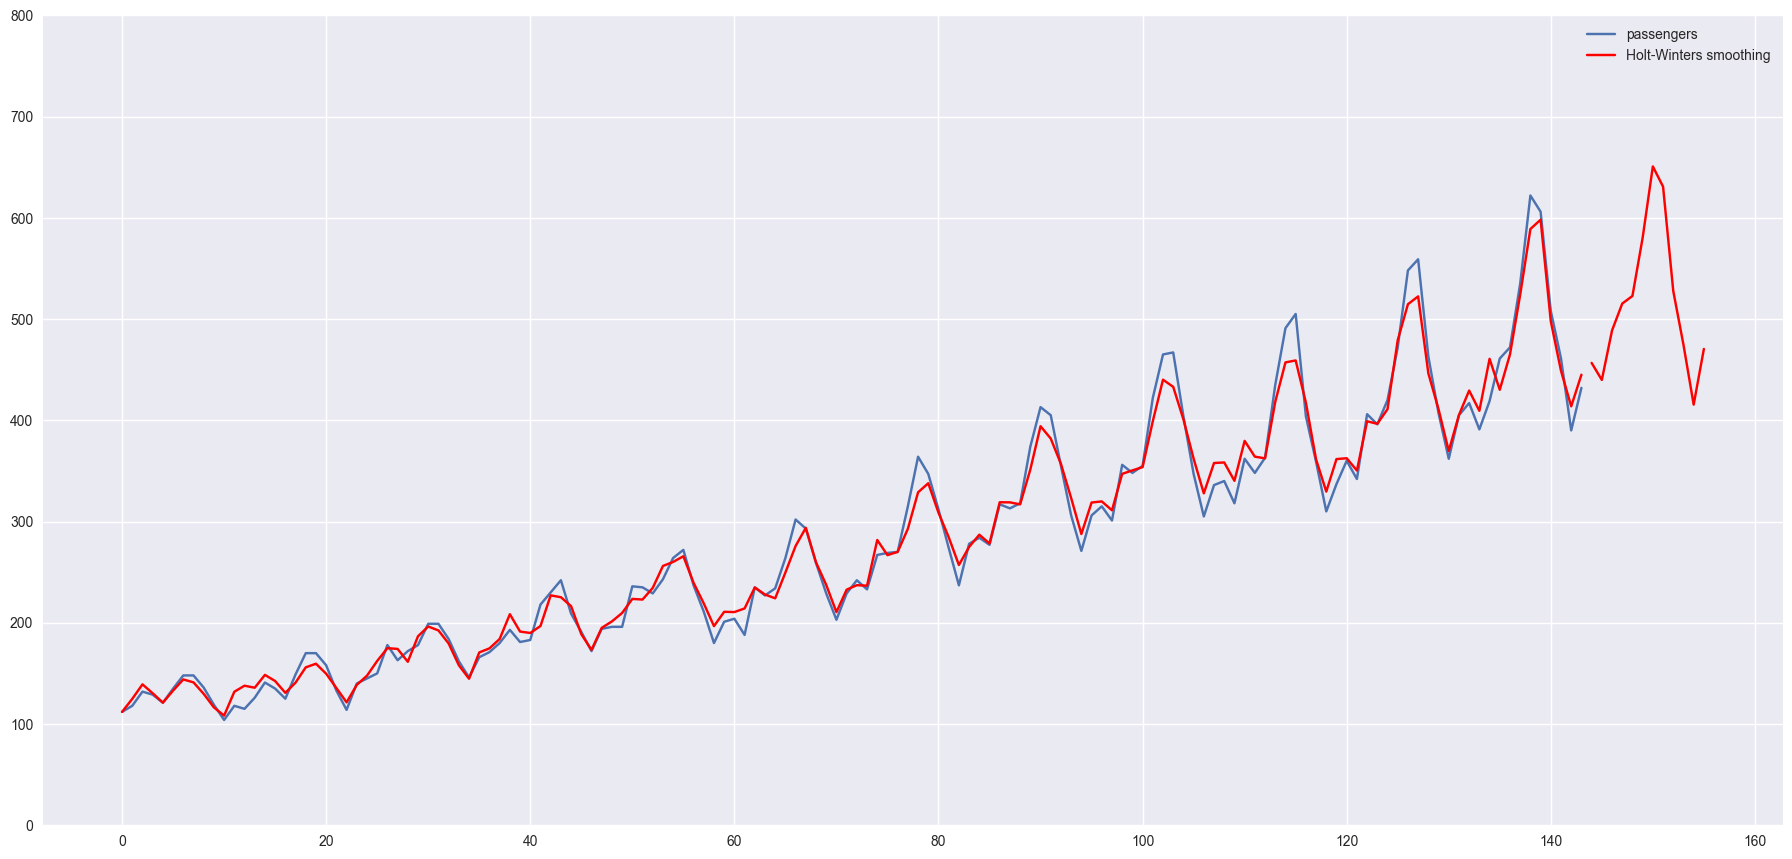

In [9]:
alpha = 0.5
df.plot.line()
fit1 = ExponentialSmoothing(df, seasonal_periods=12, trend='add', seasonal='add')
fit1 = fit1.fit(smoothing_level=0.5)
fit1.fittedvalues.plot(color='red')
fit1.forecast(12).rename("Holt-Winters smoothing").plot(color='red', legend=True)

plt.ylim(0, 800); plt.show()


This code snippet applies Holt-Winters' exponential smoothing to the "passengers" dataset, which is suitable for time series data with both trend and seasonality. It forecasts 12 periods into the future and visualizes the smoothed data (fitted values) and the forecast. 

**1. Data Loading & Initial Plotting:**

*   `alpha = 0.5`: Sets a variable `alpha`, which is used as the smoothing level in this case, but note that Holt-Winters automatically optimizes all smoothing parameters if not explicitly set.
*   `df.plot.line()`: Creates a line plot of the original time series data, showing the raw passenger numbers over time.

**2. Holt-Winters Exponential Smoothing & Fitting:**

*   `fit1 = ExponentialSmoothing(df, seasonal_periods=12, trend='add', seasonal='add')`:
    *   `ExponentialSmoothing(df, ...)`: Creates an instance of the `ExponentialSmoothing` class from `statsmodels`, initializing it with the time series data (`df`). This is the core Holt-Winters implementation.
        *   `seasonal_periods=12`: Specifies that the seasonality has a period of 12 (e.g., monthly data with yearly seasonality).  This tells the model to look for repeating patterns every 12 periods.
        *   `trend='add'`: Indicates that the trend component is additive. This means the trend is added to the seasonal and level components. Use `'mul'` for a multiplicative trend (where the trend multiplies the other components).
        *   `seasonal='add'`:  Indicates that the seasonal component is additive. This means the seasonality is added to the level and trend components. Use `'mul'` for a multiplicative seasonal component.

*   `fit1 = fit1.fit(smoothing_level=0.5)`: Fits the Holt-Winters model to the data.
    * `smoothing_level=0.5`: Sets the initial smoothing level (alpha) to 0.5.  However, because no other smoothing parameters are explicitly set, statsmodels will *optimize* all three smoothing parameters (alpha, beta for trend, and gamma for seasonality) to find the best fit to the data.

**3. Plotting Fitted Values:**

*   `fit1.fittedvalues.plot(color='red')`: Plots the fitted values (the smoothed time series) generated by the Holt-Winters model as a red line. These represent the estimated values of the time series based on the trend and seasonal components.

**4. Plotting Forecasts:**

*   `fit1.forecast(12).rename("Holt-Winters smoothing").plot(color='red', legend=True)`:
    *   `fit1.forecast(12)`: Uses the fitted model (`fit1`) to generate forecasts for the next 12 time steps (periods).
    *   `.rename(...)`: Renames the forecast series in the DataFrame to "Holt-Winters smoothing", making it easier to identify on the plot.
    *   `.plot(color='red', legend=True)`: Plots the forecasted values as a red line and adds them to the legend.

**5. Setting Y-axis Limits & Displaying Plot:**

*   `plt.ylim(0, 800)`: Sets the limits of the y-axis (vertical axis) of the plot from 0 to 800. This ensures that the entire time series and forecast are visible within the plot's bounds.
*   `plt.show()`: Displays the plot, showing the original time series, the fitted values, and the forecasts generated by Holt-Winters smoothing.

# Application: anomaly detection 

<Axes: >

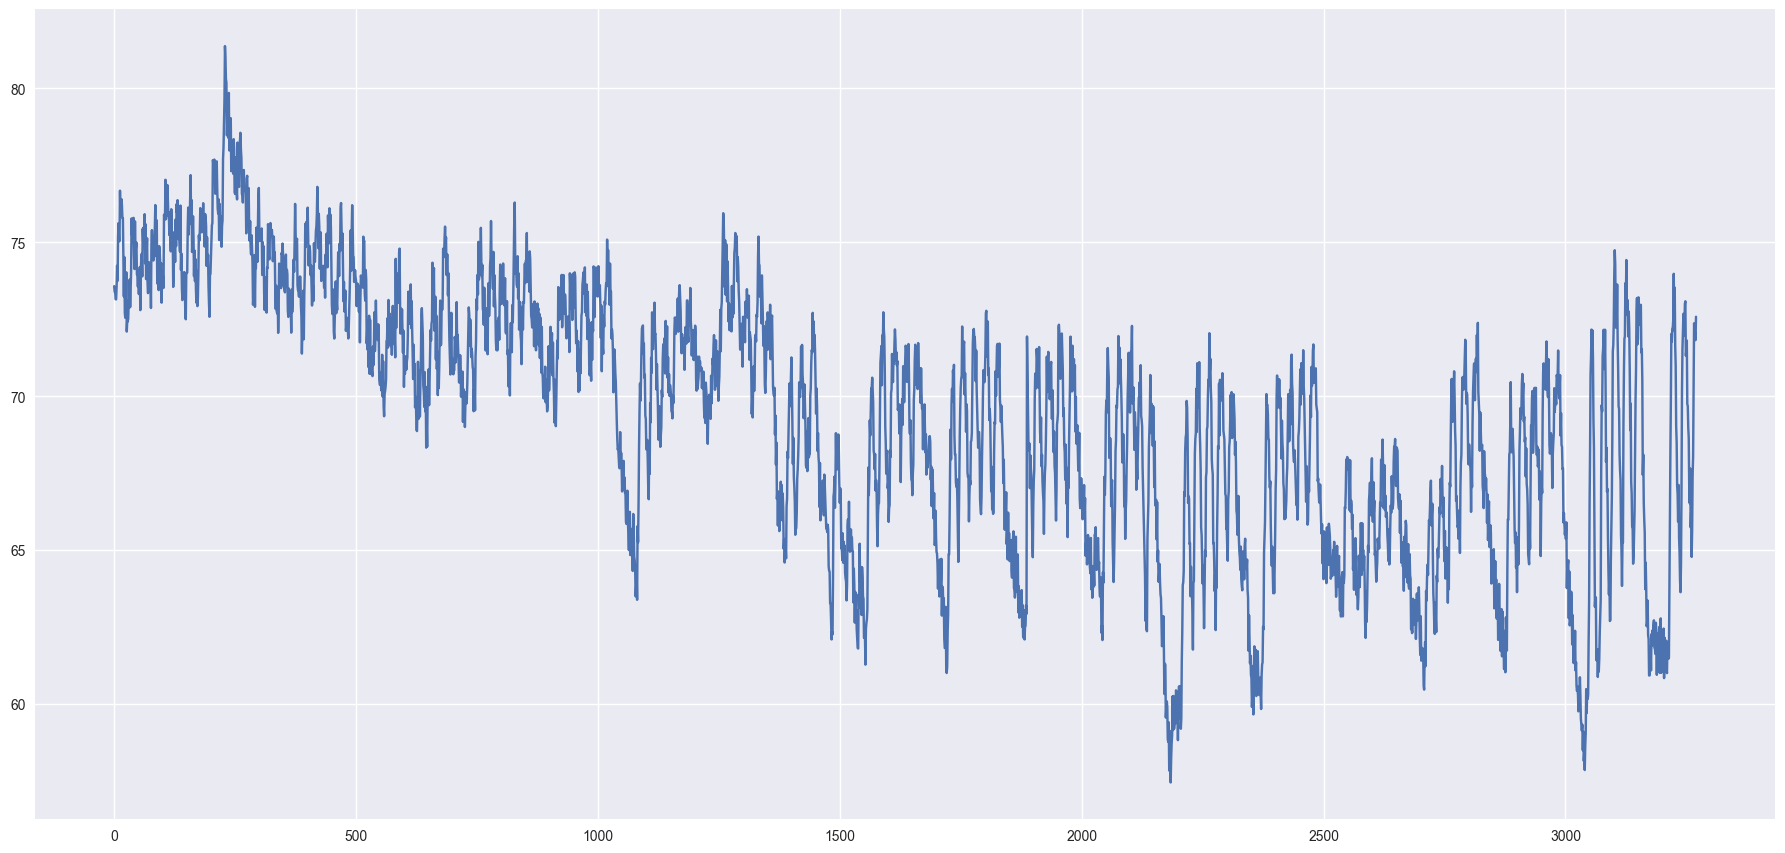

In [10]:
# load 
series = pd.read_csv(CFG.data_folder + 'ambient_temperature_system_failure.csv')
series['timestamp'] = pd.to_datetime(series['timestamp'])

# plot 
series['value'].plot()

Loads a time series dataset from a CSV file and then plots the 'value' column as a line graph over time.  

**1. Loading the Data:**

*   `series = pd.read_csv(CFG.data_folder + 'ambient_temperature_system_failure.csv')`:
    *   `pd.read_csv(...)`: Reads a CSV file named "ambient_temperature_system_failure.csv" into a Pandas DataFrame called `series`.
    *   `CFG.data_folder`: Assumes that there's a configuration object (likely defined elsewhere in the code) named `CFG`, which has an attribute `data_folder` containing the path to the directory where the data file is located. This makes the code more flexible and easier to manage if the data location changes.

*   `series['timestamp'] = pd.to_datetime(series['timestamp'])`:
    *   `series['timestamp']`: Selects the column named 'timestamp' from the DataFrame `series`.  It assumes that this column contains date/time information as strings or in a format Pandas can recognize.
    *   `pd.to_datetime(...)`: Converts the values in the 'timestamp' column to datetime objects using Pandas' `to_datetime()` function. This is crucial for time series analysis, as it allows you to perform operations like indexing by date/time and calculating time differences.  The resulting datetime objects are then assigned back to the 'timestamp' column of the DataFrame.

**2. Plotting the Time Series:**

*   `series['value'].plot()`:
    *   `series['value']`: Selects the column named 'value' from the DataFrame `series`. This is assumed to be the time series data you want to visualize (e.g., ambient temperature).
    *   `.plot()`: Creates a line plot of the values in the 'value' column, with the index (which should now be the datetime objects in the 'timestamp' column) on the x-axis and the 'value' on the y-axis.  Pandas uses Matplotlib under the hood to create this plot.

<Axes: >

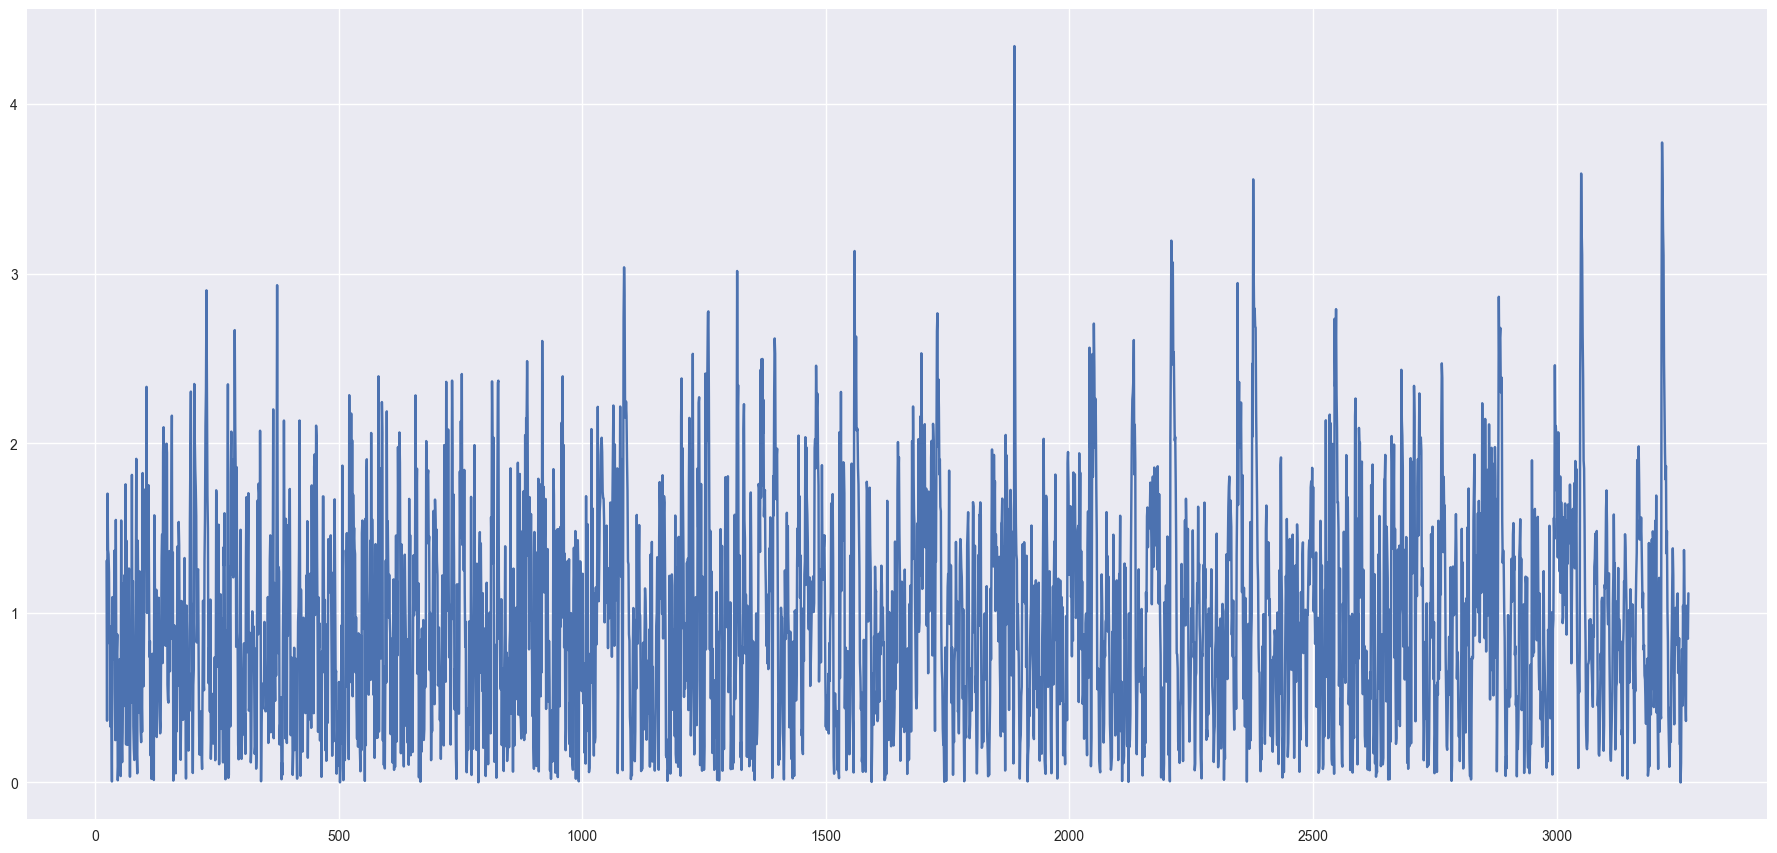

In [11]:
# pick a window size 
window_size = 25

# calculate rolling mean and standard deviation
xroll = series['value'].rolling(window_size)
series['mean_roll'] = xroll.mean()
series['sd_roll'] = xroll.std()

# calculate the Z-score
series['zscore'] = np.abs( (series['value'] - series['mean_roll']) / series['sd_roll'])
series['zscore'].plot()

We calculate the rolling mean, standard deviation, and Z-score of a time series and then plot the Z-score over time. This is a common technique for anomaly detection in time series data. 

**1. Setting Window Size:**

*   `window_size = 25`: Defines the size of the rolling window to be used for calculating the moving average and standard deviation. A larger window size will smooth out more noise but may also obscure shorter-term trends.

**2. Calculating Rolling Mean and Standard Deviation:**

*   `xroll = series['value'].rolling(window_size)`:
    *   `series['value']`: Selects the 'value' column from the DataFrame `series`.
    *   `.rolling(window_size)`: Creates a rolling window object that iterates through the 'value' column, taking chunks of size `window_size` at a time.

*   `series['mean_roll'] = xroll.mean()`:
    *   `xroll.mean()`: Calculates the mean (average) value within each rolling window.
    *   `series['mean_roll'] = ...`: Assigns the calculated rolling means to a new column named 'mean_roll' in the DataFrame `series`.

*   `series['sd_roll'] = xroll.std()`:
    *   `xroll.std()`: Calculates the standard deviation within each rolling window. The standard deviation measures the spread or dispersion of values around the mean.
    *   `series['sd_roll'] = ...`: Assigns the calculated rolling standard deviations to a new column named 'sd_roll' in the DataFrame `series`.

**3. Calculating Z-Score:**

*   `series['zscore'] = np.abs( (series['value'] - series['mean_roll']) / series['sd_roll'])`:
    *   `(series['value'] - series['mean_roll'])`: Calculates the difference between each original value and its corresponding rolling mean. This represents how much each data point deviates from the average of its surrounding values.
    *   `/ series['sd_roll']`: Divides the deviation by the rolling standard deviation. This normalizes the deviation, expressing it in terms of standard deviations away from the mean.
    *   `np.abs(...)`: Takes the absolute value of the result.  This ensures that both positive and negative deviations are treated equally when identifying anomalies. A large absolute Z-score indicates a significant deviation from the expected range based on the rolling statistics.
    *   `series['zscore'] = ...`: Assigns the calculated Z-scores to a new column named 'zscore' in the DataFrame `series`.

**4. Plotting the Z-Score:**

*   `series['zscore'].plot()`: Creates a line plot of the Z-score values over time.  This allows you to visually identify points where the Z-score is unusually high, which may indicate anomalies or outliers in the original time series data.


In [12]:
# check which observations are out of range
series.loc[series['zscore'] > 3][['timestamp', 'value']]

,timestamp,value
1086,2014-02-17 13:00:00,69.519207
1318,2014-02-27 05:00:00,69.425502
1559,2014-03-10 11:00:00,67.688348
1887,2014-03-24 19:00:00,71.943363
2209,2014-04-14 10:00:00,63.873030
2212,2014-04-14 13:00:00,66.890486
2377,2014-04-21 10:00:00,64.916813
2378,2014-04-21 11:00:00,65.396986
3050,2014-05-19 11:00:00,66.461085
3051,2014-05-19 12:00:00,68.261759


Filters the DataFrame `series` to identify and display observations where the Z-score exceeds a threshold of 3, indicating potential anomalies. 

*   `series.loc[series['zscore'] > 3]`: This is the core filtering operation.
    *   `series['zscore'] > 3`: Creates a boolean mask (a Series of True/False values) where `True` indicates that the Z-score for that row is greater than 3, and `False` otherwise.  A Z-score above 3 is often used as a threshold to identify outliers or anomalies, assuming a roughly normal distribution of data.
    *   `series.loc[...]`: Uses the `.loc[]` indexer to select rows from the DataFrame `series` based on the boolean mask. Only rows where the corresponding value in the mask is `True` will be included in the result.

*   `[['timestamp', 'value']]`: This part specifies which columns to include in the output. It selects only the 'timestamp' and 'value' columns from the filtered DataFrame.  This makes the output more concise and focuses on the relevant information (when the anomaly occurred and its value).


# Building a model

<Axes: >

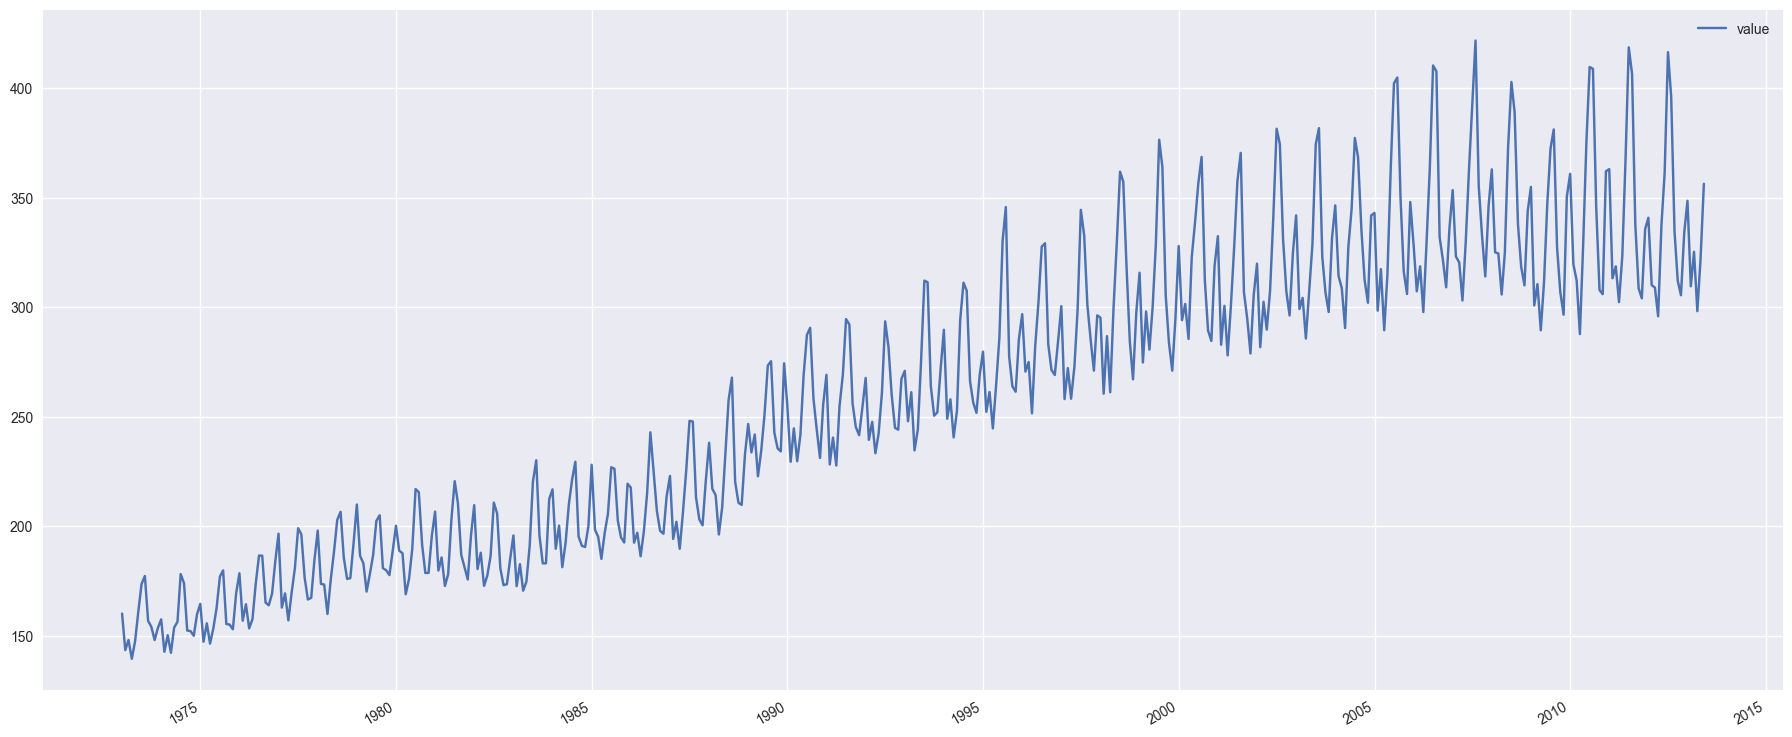

In [13]:
df = pd.read_csv(CFG.data_folder + 'us_energy.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace = True)
df.plot(xlabel="")

This load the CSV file containing US energy data, converts the 'date' column to datetime objects, sets the 'date' column as the DataFrame index, and then plots the time series data. 

**1. Loading the Data:**

*   `df = pd.read_csv(CFG.data_folder + 'us_energy.csv')`:
    *   `pd.read_csv(...)`: Reads a CSV file named "us_energy.csv" into a Pandas DataFrame called `df`.
    *   `CFG.data_folder`: Assumes that there's a configuration object (likely defined elsewhere in the code) named `CFG`, which has an attribute `data_folder` containing the path to the directory where the data file is located.

**2. Converting Date Column:**

*   `df['date'] = pd.to_datetime(df['date'])`:
    *   `df['date']`: Selects the column named 'date' from the DataFrame `df`. It assumes this column contains date information as strings or in a format Pandas can recognize.
    *   `pd.to_datetime(...)`: Converts the values in the 'date' column to datetime objects using Pandas' `to_datetime()` function. This is essential for time series analysis, allowing you to perform operations like indexing by date/time and calculating time differences. The resulting datetime objects are assigned back to the 'date' column of the DataFrame.

**3. Setting Date as Index:**

*   `df.set_index('date', inplace = True)`:
    *   `df.set_index('date')`: Sets the 'date' column as the index of the DataFrame `df`. This is a common practice in time series analysis, as it allows you to easily access data by date and perform time-based operations.
    *   `inplace = True`: Modifies the DataFrame `df` directly without creating a new copy.

**4. Plotting the Time Series:**

*   `df.plot(xlabel="")`: Creates a line plot of the time series data.  Since 'date' is now the index, Pandas automatically uses it as the x-axis.
    *   `xlabel=""`: Sets the label for the x-axis to an empty string, effectively removing the x-axis label from the plot. This might be done if the date information on the x-axis is already clear or if a custom label will be added later.


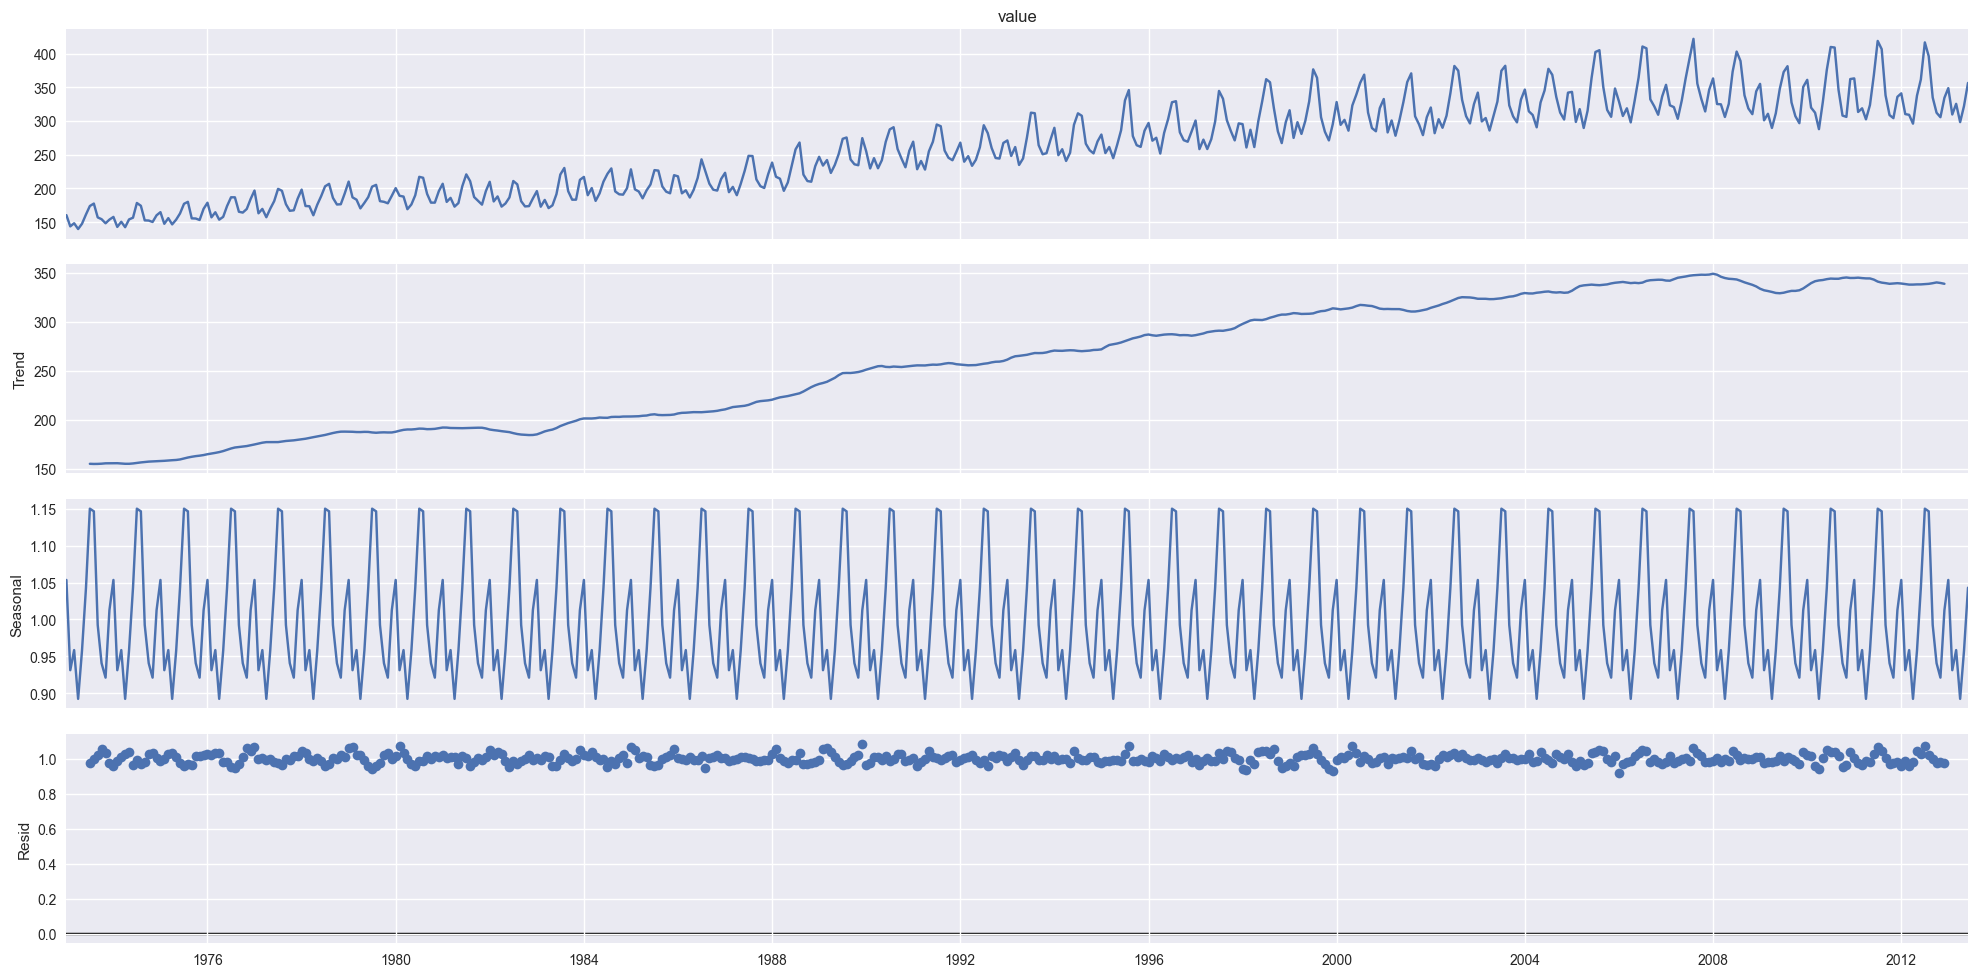

In [14]:
decomposition = seasonal_decompose(df["value"],period =12, model = 'multiplicative')
figure = decomposition.plot()
plt.show()

This part performs a seasonal decomposition of the "value" column from your DataFrame `df` and then plots the decomposed components (trend, seasonality, and residual).

**1. Seasonal Decomposition:**

*   `decomposition = seasonal_decompose(df["value"], period=12, model='multiplicative')`:
    *   `seasonal_decompose(...)`: This function from `statsmodels.tsa.seasonal` decomposes a time series into its constituent components: trend, seasonality, and residual (random noise).
        *   `df["value"]`: Specifies the time series data to be decomposed – in this case, the 'value' column of your DataFrame `df`.
        *   `period=12`:  Specifies the length of the seasonal cycle. A period of 12 is appropriate for monthly data with yearly seasonality (e.g., sales that peak every December).
        *   `model='multiplicative'`: Specifies the type of decomposition model to use.
            *   **Multiplicative:** Assumes that the seasonal component varies proportionally to the level of the time series.  This is appropriate when the magnitude of the seasonal fluctuations increases or decreases with the overall trend. The formula would be: `observed = trend * seasonality * residual`.
            *   **Additive:** (The default if not specified) Assumes that the seasonal component has a constant magnitude regardless of the level of the time series.  The formula would be: `observed = trend + seasonality + residual`.

**2. Plotting the Decomposition:**

*   `figure = decomposition.plot()`:
    *   `decomposition.plot()`: Creates a plot showing the original time series along with its decomposed components (trend, seasonality, and residual). The function returns a Matplotlib figure object.
    *   `figure = ...`: Assigns the returned figure object to the variable `figure`.  This allows you to further customize the plot if needed.

**3. Displaying the Plot:**

*   `plt.show()`: Displays the generated plot, showing the original time series and its decomposed components. The plot will typically have four subplots:
    *   The original time series.
    *   The estimated trend component.
    *   The estimated seasonal component.
    *   The residual (random noise) component.


In [24]:

cutoff_date = '2005-12-31'
train_df, valid_df = train_valid_split(df, cutoff_date)

TODO

In [16]:
fit1 = ExponentialSmoothing(train_df['value'].values, seasonal_periods=12, trend='mul', seasonal='mul')
fit1 = fit1.fit()

TODO

In [17]:
fit1.params_formatted

,name,param,optimized
smoothing_level,alpha,0.281657,True
smoothing_trend,beta,0.000000,True
smoothing_seasonal,gamma,0.226347,True
initial_level,l.0,155.198901,True
initial_trend,b.0,1.001948,True
initial_seasons.0,s.0,1.044362,True
initial_seasons.1,s.1,0.919946,True
initial_seasons.2,s.2,0.944655,True
initial_seasons.3,s.3,0.877853,True
initial_seasons.4,s.4,0.927012,True


Retrieve the  optimized parameter values (smoothing levels) from the fitted Holt-Winters exponential smoothing model (`fit1`):

*   `fit1.params_formatted`: This accesses the `params_formatted` attribute of the fitted `ExponentialSmoothing` object (`fit1`).
    *   `params_formatted`:  This is a Pandas Series that contains the optimized values for the smoothing parameters (alpha, beta, and gamma) used in the Holt-Winters model. It also includes their names and standard errors. The formatting makes it easy to read and understand the results of the optimization process.

*   `level`: Represents alpha (α), the smoothing level for the level component of the time series.  It controls how much weight is given to recent observations when estimating the current level.
*   `trend`: Represents beta (β), the smoothing factor for the trend component. It controls how much weight is given to recent changes in the slope (trend) of the series.
*   `seasonal`: Represents gamma (γ), the smoothing factor for the seasonal component.  It controls how much weight is given to recent seasonal fluctuations.


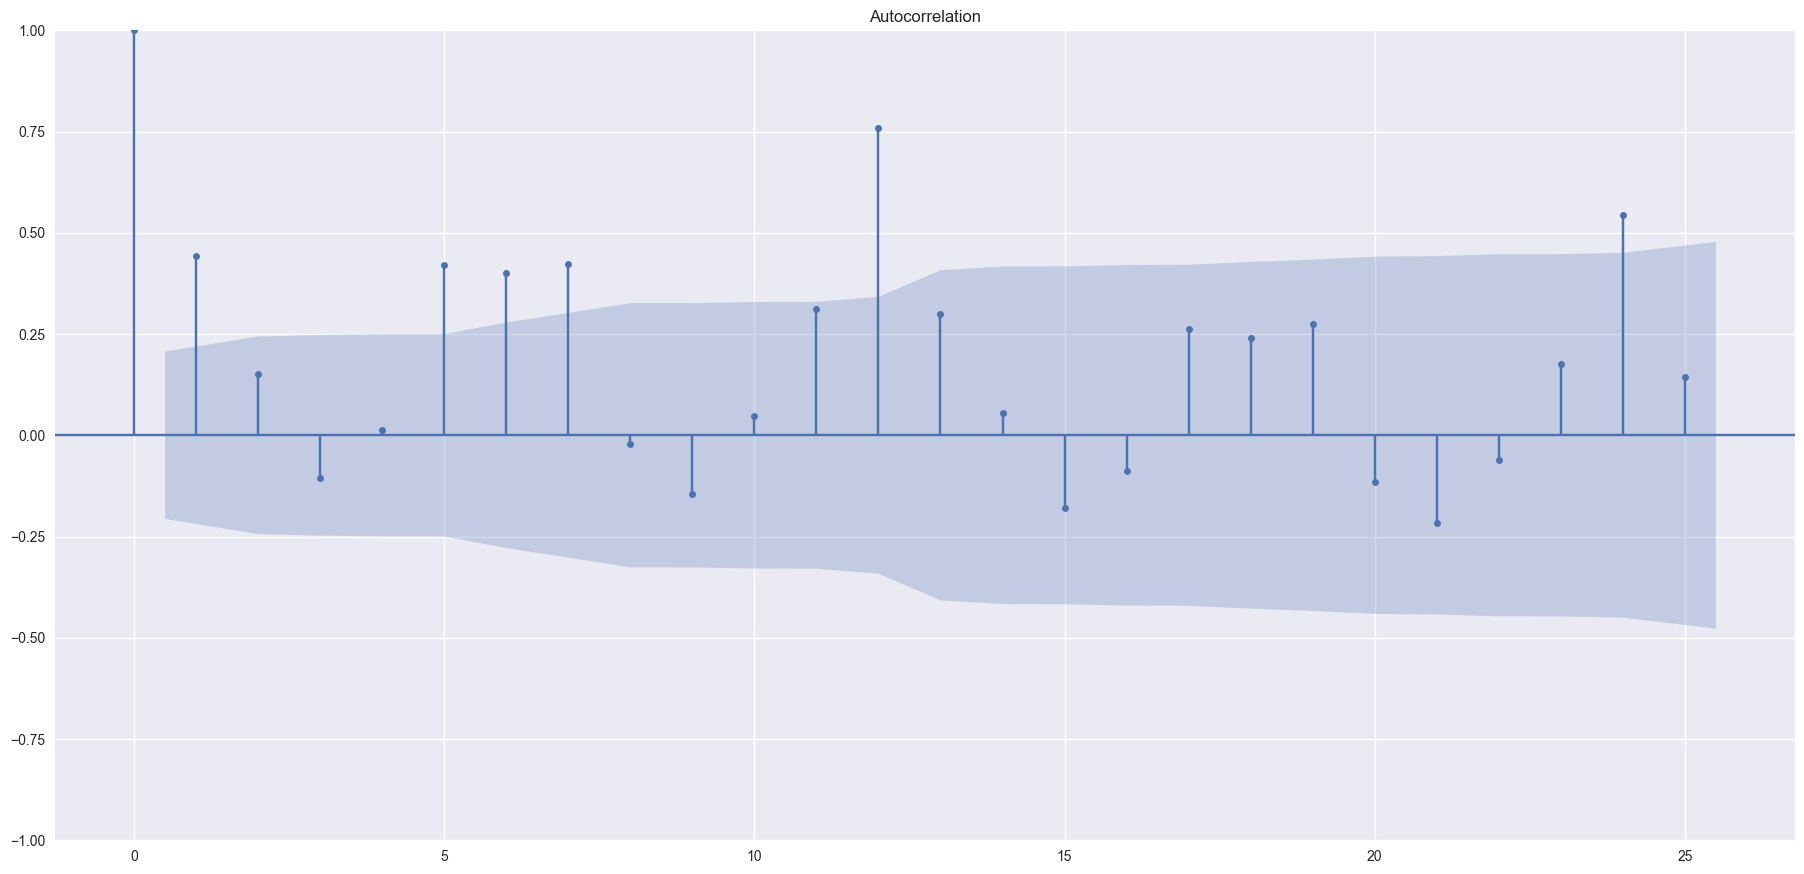

In [18]:
# What do the residuals look like?
prediction = fit1.forecast(len(valid_df)).copy()

xresiduals = valid_df['value'] - prediction
plot_acf(xresiduals, lags = 25)
print()

This part analyzes the residuals (the differences between actual and predicted values) from your Holt-Winters model to assess its performance.  

**1. Forecasting on Validation Data:**

*   `prediction = fit1.forecast(len(xvalid)).copy()`:
    *   `fit1.forecast(len(xvalid))`: Uses the fitted Holt-Winters model (`fit1`) to generate forecasts for a number of periods equal to the length of your validation set (`xvalid`). This creates a Pandas Series containing the predicted values.
    *   `.copy()`: Creates a copy of the forecast series.  This is important to avoid potential issues with modifying the original forecast data unintentionally.

**2. Calculating Residuals:**

*   `xresiduals = xvalid['value'] - prediction`:
    *   `xvalid['value']`: Selects the actual values from the 'value' column of your validation set (`xvalid`).
    *   `- prediction`: Subtracts the predicted values (from `prediction`) from the actual values. The result is a Pandas Series containing the residuals – the differences between what actually happened and what the model predicted.

**3. Analyzing Residuals with ACF Plot:**

*   `plot_acf(xresiduals, lags = 25)`:
    *   `plot_acf(...)`:  This function from `statsmodels.graphics.tsaplots` creates an Autocorrelation Function (ACF) plot of the residuals. The ACF plot shows the correlation between the residuals and their lagged values.
        *   `xresiduals`: Provides the series of residuals to be analyzed.
        *   `lags = 25`: Specifies the maximum number of lags to include in the ACF plot.  A lag represents a time step back from the current observation.

**4. Printing an Empty Line:**

*   `print()`: Prints an empty line to add some visual separation between the ACF plot and any subsequent output. This is purely for formatting purposes.


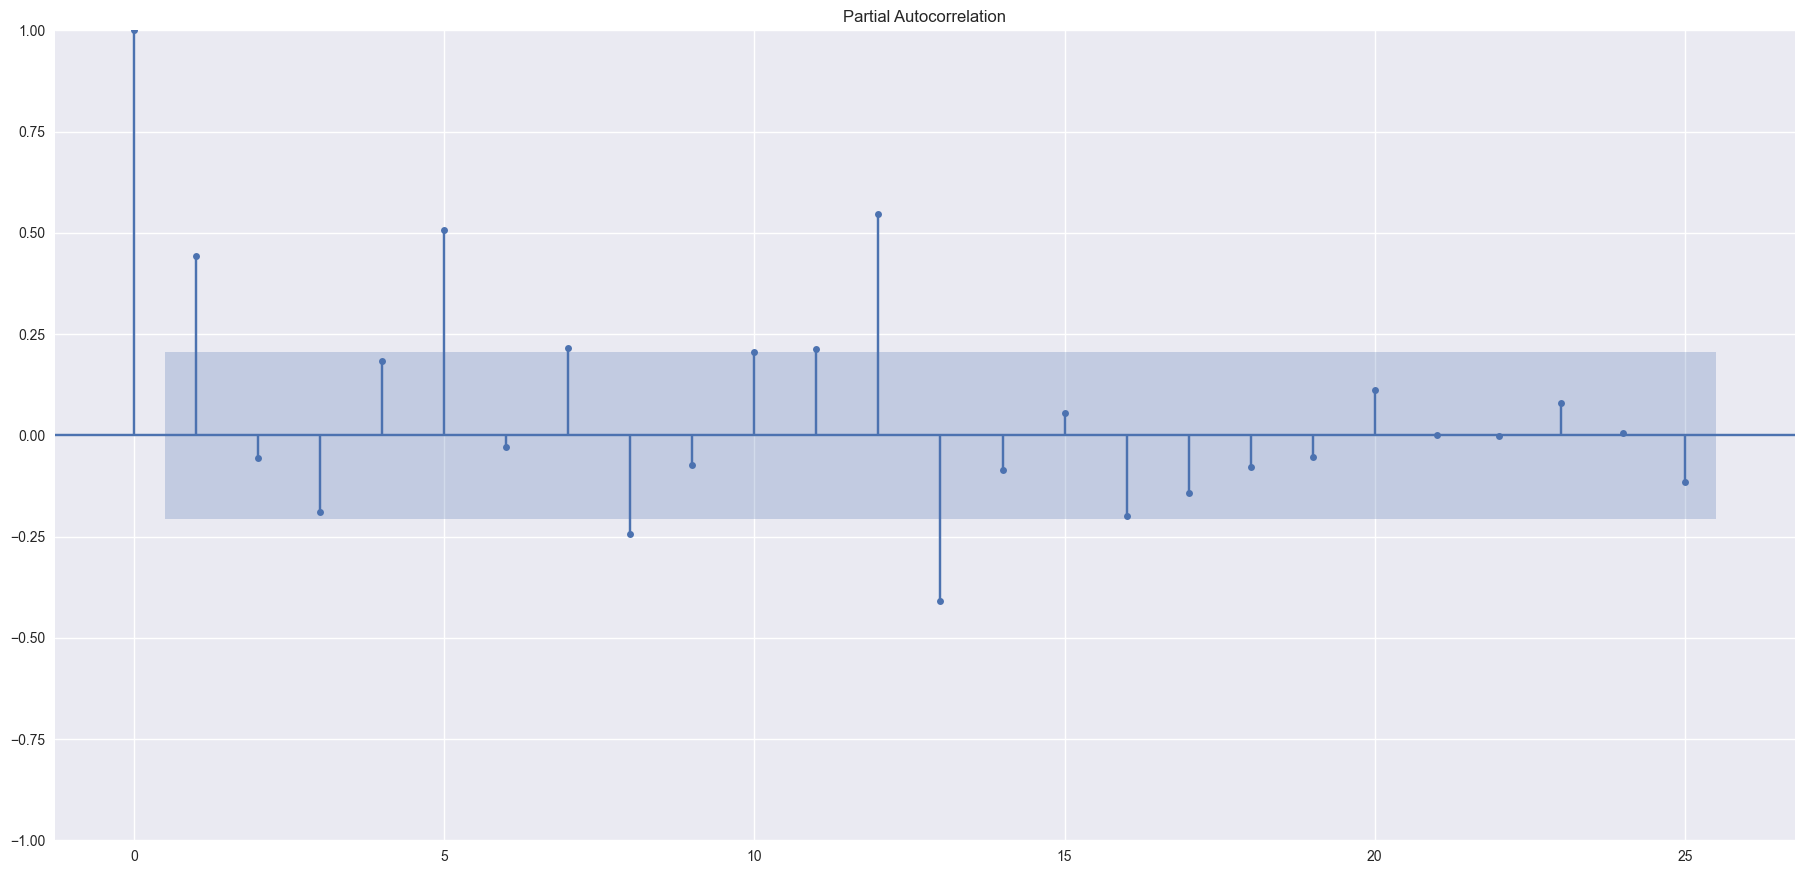

In [19]:
plot_pacf(xresiduals, lags = 25)
print()

This code analyzes the residuals from your Holt-Winters model using a Partial Autocorrelation Function (PACF) plot to further assess its performance and identify potential areas for improvement.  

*   `plot_pacf(xresiduals, lags = 25)`:
    *   `plot_pacf(...)`: This function from `statsmodels.graphics.tsaplots` creates a Partial Autocorrelation Function (PACF) plot of the residuals. The PACF plot shows the correlation between the residuals and their lagged values *after removing the effects of intermediate lags*.  This helps to identify the direct relationship between an observation and its past values, without being influenced by other intervening observations.
        *   `xresiduals`: Provides the series of residuals (calculated in the previous step) to be analyzed.
        *   `lags = 25`: Specifies the maximum number of lags to include in the PACF plot.

*   `print()`: Prints an empty line for visual separation, similar to the previous code snippet.


In [20]:

xvalid['prediction'] = prediction
xvalid.plot()

NameError: name 'xvalid' is not defined

The code adds the forecasted values as a new column to your validation DataFrame (`xvalid`) and then creates a plot showing both the actual values and the forecasts over time. 

*   `xvalid['prediction'] = prediction`:
    *   `xvalid['prediction']`: Creates a new column named 'prediction' in the `xvalid` DataFrame.
    *   `= prediction`: Assigns the forecasted values (stored in the `prediction` variable) to this new column.  Now, your validation DataFrame contains both the actual observed values ('value') and the corresponding predicted values ('prediction').

*   `xvalid.plot()`:
    *   `xvalid.plot()`: Creates a line plot of all numerical columns in the `xvalid` DataFrame. Since you have 'value' (the actual data) and 'prediction' (the forecasted data), Pandas will create a plot with two lines: one for the actual values and one for the predicted values.  The index of the DataFrame (which is the date/time) will be used as the x-axis.
